Train: 0.850, Test: 0.815


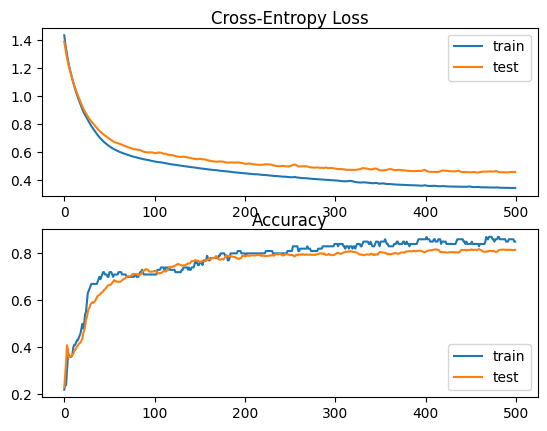

In [3]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [8]:
# example of saving sub-models for later use in a stacking ensemble
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from os import makedirs

# fit model on dataset
def fit_model(trainX, trainy):
  # define model
  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit model
  model.fit(trainX, trainy, epochs=500, verbose=0)
  return model

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variabley = to_categorical(y)
# split into train and test
y = to_categorical(y)
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# create directory for models
makedirs('models', exist_ok=True)
# fit and save models
n_members = 5
for i in range(n_members):
  # fit model
  model = fit_model(trainX, trainy)
  # save model
  filename = 'models/model_' + str(i + 1) + '.h5'
  model.save(filename)
  print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


In [10]:
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from numpy import dstack

# load models from file
def load_all_models(n_models):
  all_models = list()
  for i in range(n_models):
    # define filename for this ensemble
    filename = 'models/model_' + str(i + 1) + '.h5'
    # load model from file
    model = load_model(filename)
    # add to list of members
    all_models.append(model)
    print('>loaded %s' % filename)
  return all_models

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
  stackX = None
  for model in members:
    # make prediction
    yhat = model.predict(inputX, verbose=0)
    # stack predictions into [rows, members, probabilities]
    if stackX is None:
      stackX = yhat
    else:
      stackX = dstack((stackX, yhat))
  # flatten predictions to [rows, members x probabilities]
  stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
  return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
  # create dataset using ensemble
  stackedX = stacked_dataset(members, inputX)
  # fit standalone model
  model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
  model.fit(stackedX, inputy)
  return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
  # create dataset using ensemble
  stackedX = stacked_dataset(members, inputX)
  # make a prediction
  yhat = model.predict(stackedX)
  return yhat

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
  testy_enc = to_categorical(testy)
  _, acc = model.evaluate(testX, testy_enc, verbose=0)
  print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models
Model Accuracy: 0.815
Model Accuracy: 0.807
Model Accuracy: 0.812
Model Accuracy: 0.812
Model Accuracy: 0.806
Stacked Test Accuracy: 0.833


In [13]:
# stacked generalization with neural net meta model on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Dense
from keras.layers import concatenate
from numpy import argmax

# load models from file
def load_all_models(n_models):
  all_models = list()
  for i in range(n_models):
    # define filename for this ensemble
    filename = 'models/model_' + str(i + 1) + '.h5'
    # load model from file
    model = load_model(filename)
    # add to list of members
    all_models.append(model)
    print('>loaded %s' % filename)
  return all_models

# define stacked model from multiple member input models
def define_stacked_model(members):
  # update all layers in all models to not be trainable
  for i in range(len(members)):
    model = members[i]
    for layer in model.layers:
      # make not trainable
      layer.trainable = False
      # rename to avoid 'unique layer name' issue
      # layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
  # define multi-headed input
  ensemble_visible = [model.input for model in members]
  # concatenate merge output from each model
  ensemble_outputs = [model.output for model in members]
  merge = concatenate(ensemble_outputs)
  hidden = Dense(10, activation='relu')(merge)
  output = Dense(3, activation='softmax')(hidden)
  model = Model(inputs=ensemble_visible, outputs=output)
  # plot graph of ensemble
  plot_model(model, show_shapes=True, to_file='model_graph.png')
  # compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
  # prepare input data
  X = [inputX for _ in range(len(model.input))]
  # encode output data
  inputy_enc = to_categorical(inputy)
  # fit model
  model.fit(X, inputy_enc, epochs=300, verbose=0)

# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
  # prepare input data
  X = [inputX for _ in range(len(model.input))]
  # make prediction
  return model.predict(X, verbose=0)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, testX, testy)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, testX)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models
Stacked Test Accuracy: 0.833
